# Task 2 Encoding and Classifier


Encoding the following files in a quantum circuit mock_train_set.csv and mock_test_set.csv in at least two different ways (these could be basis, angle,  amplitude, kernel or random encoding).
Design a variational quantum circuit for each of the encodings, uses the column 4  as the target,  this is a binary class 0 and 1.
You must  use the data  from column0 to column3 for your proposed classifier. 
Consider the ansatz you are going to design as a layer and find out how many layers are necessary to reach the best performance.

Analyze and discuss the results.

Feel free to use existing frameworks (e.g. PennyLane, Qiskit) for creating and training the circuits.
This PennyLane demo can be useful: Training a quantum circuit with Pytorch, 
This Quantum Tensorflow tutorial can be useful: Training a quantum circuit with Tensorflow.

For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RZ and CNOTs.

# Imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize as optimize
import csv
import matplotlib.pyplot as plt

# Data Pre-processing
## Load Raw Data

In [2]:
def read_file(filename):
    """Read csv file
    Args:
      - filename (string): the file name
    Returns:
      - rows (list): a list of rows in the file
    """
    rows = []
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)
    return rows

train_dataset = np.array(read_file("mock_train_set.csv"), dtype=float)
test_dataset = np.array(read_file("mock_test_set.csv"), dtype=float)

train_X, train_Y = train_dataset[1:, 0:4], train_dataset[1:, 4].astype('int')
test_X, test_Y = test_dataset[1:, 0:4], test_dataset[1:, 4].astype('int')

# shift label from {0, 1} to {-1, 1}
train_Y = train_Y * 2 - np.ones(len(train_Y))
test_Y = test_Y * 2 - np.ones(len(test_Y))

print("The size of the training dataset:", train_X.shape)
print("The size of the test dataset:", test_X.shape)
print("The size of the training label:", train_Y.shape)
print("The size of the test label:", test_Y.shape)

The size of the training dataset: (300, 4)
The size of the test dataset: (120, 4)
The size of the training label: (300,)
The size of the test label: (120,)


As can be seen, the data size is not large, with 300 training data and 120 test data. In the later training, the training data will be further split into training data (75%) and validation data (25%).

## Data Min-Max Normalization (Each Column)

For the data attributes, the value ranges in each column is quite different. To aid the convergence of the training, the min-max normalization is applied for each column of the datasets.

In [3]:
# normalize data for each column 1, 2, 3, 4
def find_min_and_max(arr1, arr2):
    """Find max and min values for each column in datasets
    Args:
      - arr1, arr2: the datasets
    Returns:
      - arr_max, arr_min: arrays with max and min elements in each column, respectively
    """
    arr1_max = np.max(arr1, axis=0)
    arr2_max = np.max(arr2, axis=0)
    arr_max = np.maximum(arr1_max, arr2_max)
    
    arr1_min = np.min(arr1, axis=0)
    arr2_min = np.min(arr2, axis=0)
    arr_min = np.minimum(arr1_min, arr2_min)
    
    return arr_max, arr_min   

In [4]:
X_max, X_min = find_min_and_max(train_X, test_X)
print("The max for each column:", X_max)
print("The min for each column:", X_min)

The max for each column: [4.99561e+03 1.00000e+06 1.00000e+06 9.00000e+01]
The min for each column: [31.71  1.    1.    1.  ]


In [5]:
# min-max normalization 
for i in range(train_X.shape[1]):
    train_X[:, i] = (train_X[:, i] - X_min[i]) / (X_max[i] - X_min[i])
    test_X[:, i] = (test_X[:, i] - X_min[i]) / (X_max[i] - X_min[i])

In [6]:
print("First training X sample (min-max normalization): ", train_X[0])
print("First test X sample (min-max normalization): ", test_X[0])

First training X sample (min-max normalization):  [5.55520861e-01 9.99000999e-04 9.00000900e-06 2.13483146e-01]
First test X sample (min-max normalization):  [0.59566873 0.00999901 0.00999901 0.83146067]


## Normalize to 1.0 (Each Row)

In [7]:
# normazlie each input
normalization_train, normalization_test = np.sqrt(np.sum(train_X ** 2, -1)), np.sqrt(np.sum(test_X ** 2, -1))
train_X_norm, test_X_norm = (train_X.T / normalization_train).T, (test_X.T / normalization_test).T
print("First training X sample (normalized):", train_X_norm[0])
print("First test X sample (normalized):", test_X_norm[0])

First training X sample (normalized): [9.33444874e-01 1.67862708e-03 1.51227665e-05 3.58716949e-01]
First test X sample (normalized): [0.58232672 0.00977505 0.00977505 0.81283731]


# Quantum Classifier 
In this section, two state embedding methods are explored, they are amplitude embedding and angle embedding. Because the feature size is 4, for amplitude embedding, we only need 2 qubits, for angle embedding, we need 4 qubits.
## 1. Classifier based on Amplitude Embedding
### Quantum Circuit

In [8]:
def square_loss(labels, predictions):
    """Find square loss between labels and predictions
    Args:
      - labels: the sample labels
      - predictions: the predicted labels
    Returns:
      - loss: square loss 
    """
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    """Find prediction accuracy
    Args:
      - labels: the sample labels
      - predictions: the predicted labels
    Returns:
      - accuracy: percentage of right prediction
    """
    accuracy = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            accuracy = accuracy + 1
    accuracy = accuracy / len(labels)

    return accuracy

In [9]:
def layer_amplitude_embedding(W):    
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

dev_amplitude_embedding = qml.device("default.qubit", wires=2)
@qml.qnode(dev_amplitude_embedding)
def circuit_amplitude_embedding(weights, feature):
    """A quantum circuit used as classifier
    Args:
      - weights: parameters for layers in the circuit
      - feature: sample data
    Returns:
      - expectation value: expectation value of Pauli z operator
    """
    qml.AmplitudeEmbedding(feature, wires=[0, 1], normalize=True)

    for W in weights:
        layer_amplitude_embedding(W)

    return qml.expval(qml.PauliZ(0))

def variational_classifier_amplitude_embedding(weights, bias, feature):
    return circuit_amplitude_embedding(weights, feature) + bias

def cost_amplitude_embedding(weights, bias, features, labels):
    predictions = [variational_classifier_amplitude_embedding(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

### Optimization 

In [10]:
# partition training datasets to training and validation 
np.random.seed(0)
num_data = len(train_Y)
num_train = int(0.75 * num_data) # 75% dataset is used for training
index = np.random.permutation(range(num_data))
feats_train = train_X_norm[index[:num_train]]
label_train = train_Y[index[:num_train]]
feats_val = train_X_norm[index[num_train:]]
label_val = train_Y[index[num_train:]]

In [11]:
batch_size = 5
num_qubits = 2 # 2 qubits are needed for quantum circuit based on amplitude embedding
num_layers = [1, 3, 6, 8, 10]
accuracy_amplitude_embedding = []

for i in range(len(num_layers)):
    opt = optimize.NesterovMomentumOptimizer(0.01)
    print("Convergence for number of layers is equal to : {}".format(num_layers[i]))
    print("----------------------------------------------------------------------")
    # train the variational classifier      
    weights = 0.01 * np.random.randn(num_layers[i], num_qubits, 3, requires_grad=True)
    bias =  np.array(0.0, requires_grad=True)
    for it in range(60):
        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        label_train_batch = label_train[batch_index]
        weights, bias, _, _ = opt.step(cost_amplitude_embedding, weights, bias, feats_train_batch, label_train_batch)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier_amplitude_embedding(weights, bias, f)) for f in feats_train]
        predictions_val = [np.sign(variational_classifier_amplitude_embedding(weights, bias, f)) for f in feats_val]

        # Compute accuracy on train and validation set
        acc_train = accuracy(label_train, predictions_train)
        acc_val = accuracy(label_val, predictions_val)
        
        if it%10 == 0:
            print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(it + 1, cost_amplitude_embedding(weights, bias, train_X_norm, train_Y), acc_train, acc_val)
            )
    # check test accuracy
    predictions_test = [np.sign(variational_classifier_amplitude_embedding(weights, bias, f)) for f in test_X_norm]
    acc_test = accuracy(test_Y, predictions_test)
    print("Test accuracy:", acc_test)
    accuracy_amplitude_embedding.append(acc_test)

Convergence for number of layers is equal to : 1
----------------------------------------------------------------------


C:\Users\12345\Anaconda3\envs\hackq\lib\site-packages\autograd\numpy\numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)


Iter:     1 | Cost: 1.2496464 | Acc train: 0.5600000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.2165535 | Acc train: 0.5600000 | Acc validation: 0.5600000 
Iter:    21 | Cost: 1.2037583 | Acc train: 0.5955556 | Acc validation: 0.5600000 
Iter:    31 | Cost: 1.2350238 | Acc train: 0.5866667 | Acc validation: 0.5466667 
Iter:    41 | Cost: 1.0280630 | Acc train: 0.6222222 | Acc validation: 0.6000000 
Iter:    51 | Cost: 0.8945497 | Acc train: 0.6755556 | Acc validation: 0.6400000 
Test accuracy: 0.8583333333333333
Convergence for number of layers is equal to : 3
----------------------------------------------------------------------
Iter:     1 | Cost: 1.2523830 | Acc train: 0.5600000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.2246969 | Acc train: 0.5644444 | Acc validation: 0.5600000 
Iter:    21 | Cost: 1.1035576 | Acc train: 0.6133333 | Acc validation: 0.6133333 
Iter:    31 | Cost: 0.9144311 | Acc train: 0.6711111 | Acc validation: 0.6533333 
Iter:    41 | Cost: 0.8051

## 2. Classifier based on Angle Embedding
### Quantum Circuit

In [12]:
def layer_angle_embedding(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0]) 
    
dev_angle_embedding = qml.device("default.qubit", wires=4)
@qml.qnode(dev_angle_embedding)
def circuit_angle_embedding(weights, angles):
    """A quantum circuit used as classifier
    Args:
      - weights: parameters for layers in the circuit
      - feature: sample data
    Returns:
      - expectation value: expectation value of Pauli z operator
    """
    qml.AngleEmbedding(angles, wires=range(4), rotation='Z')

    for W in weights:
        layer_angle_embedding(W)

    return qml.expval(qml.PauliZ(0))

def variational_classifier_angle_embedding(weights, bias, angles):
    return circuit_angle_embedding(weights, angles) + bias

def cost_angle_embedding(weights, bias, features, labels):
    predictions = [variational_classifier_angle_embedding(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

### Optimization 

In [13]:
batch_size = 5
num_qubits = 4 # 4 qubits are needed for quantum circuit based on angle embedding
num_layers = [1, 3, 6, 8, 10]
accuracy_angle_embedding = []

for i in range(len(num_layers)):
    opt = optimize.NesterovMomentumOptimizer(0.01)
    print("Convergence for number of layers is equal to : {}".format(num_layers[i]))
    print("----------------------------------------------------------------------")
    # train the variational classifier
    weights = 0.01 * np.random.randn(num_layers[i], num_qubits, 3, requires_grad=True)
    bias = np.array(0.0, requires_grad=True)
    for it in range(60):
        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        label_train_batch = label_train[batch_index]
        weights, bias, _, _ = opt.step(cost_angle_embedding, weights, bias, feats_train_batch, label_train_batch)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier_angle_embedding(weights, bias, f)) for f in feats_train]
        predictions_val = [np.sign(variational_classifier_angle_embedding(weights, bias, f)) for f in feats_val]

        # Compute accuracy on train and validation set
        acc_train = accuracy(label_train, predictions_train)
        acc_val = accuracy(label_val, predictions_val)
        
        if it%10 == 0:
            print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(it + 1, cost_angle_embedding(weights, bias, train_X_norm, train_Y), acc_train, acc_val)
            )
    # check test accuracy
    predictions_test = [np.sign(variational_classifier_angle_embedding(weights, bias, f)) for f in test_X_norm]
    acc_test = accuracy(test_Y, predictions_test)
    print("Test accuracy:", acc_test)
    accuracy_angle_embedding.append(acc_test)

Convergence for number of layers is equal to : 1
----------------------------------------------------------------------
Iter:     1 | Cost: 2.0434767 | Acc train: 0.4888889 | Acc validation: 0.4400000 
Iter:    11 | Cost: 1.0767405 | Acc train: 0.4888889 | Acc validation: 0.4400000 
Iter:    21 | Cost: 1.0164683 | Acc train: 0.5111111 | Acc validation: 0.5600000 
Iter:    31 | Cost: 0.9984465 | Acc train: 0.5111111 | Acc validation: 0.5600000 
Iter:    41 | Cost: 1.0059378 | Acc train: 0.4888889 | Acc validation: 0.4400000 
Iter:    51 | Cost: 1.0011451 | Acc train: 0.4888889 | Acc validation: 0.4400000 
Test accuracy: 0.5166666666666667
Convergence for number of layers is equal to : 3
----------------------------------------------------------------------
Iter:     1 | Cost: 2.0593690 | Acc train: 0.4888889 | Acc validation: 0.4400000 
Iter:    11 | Cost: 1.1890292 | Acc train: 0.4888889 | Acc validation: 0.4400000 
Iter:    21 | Cost: 1.0129898 | Acc train: 0.5111111 | Acc validation:

# Results and Analysis

Based on the results with current hyperparameters used in the training, amplitude embedding performs much better than angle embedding. While the best accuracy achieved by amplitude embedding can reach 85.8% with 1 and 6 layers of ansatz, angle embedding can only reach 51.6% accuracy with 1, 6, and 8 layers of anstaz. In addition, the impact of the number of ansatz is not apparent according to the limited sample data presented in the current analysis. By its current state, as indicated in the results, 6 layers of ansatz turns to be the best. 

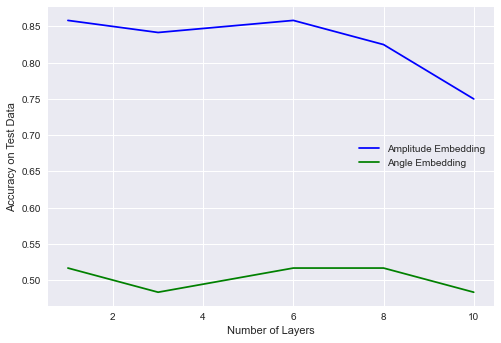

In [15]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(num_layers, accuracy_amplitude_embedding, "b", label="Amplitude Embedding")
plt.plot(num_layers, accuracy_angle_embedding, "g", label="Angle Embedding")

plt.ylabel("Accuracy on Test Data")
plt.xlabel("Number of Layers")
plt.legend()
plt.show()